# **Preparation**

CalcValueNoUnc() and ArbValue()

In [ ]:
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import date
import tensorflow as tf
from datetime import date

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Compute current value function using the value function from the next time period
def CalcValueNoUnc(d, c, P, eta, vi, ed, iC, iD):
    """
    Title: Calculate Risk-Neutral value function using deterministic price
    Inputs:
        d - price right now
        c - marginal discharge cost
        P - power rating w.r.t to energy rating and sampling time,
        i.e., 2hr duration battery with 5min resolution -> P = (1/2)/12 
        eta - efficiency
        vi - input value function for the next time period, which equals to
        v_t(e) where e is sampled from 0 to 1 at the granularity e
        ed - granularity at which vi is sampled, in p.u. to energy rating
    Outputs:
        vo - value function for the current time period sampled at ed
    """
    # add a large number of upper and lower v, where the first point is
    # v_t(0-) = +infty, and the second point is v_t(0), the second largest one is
    # v_t(1), and the largest one is v_t(1+) = -infty
    lNum = 1e5*np.ones((1,))
    v_foo = np.concatenate([lNum, vi, -lNum], axis=0)

    # # calculate soc after charge vC = v_t(e+P*eta)
    vC = v_foo[iC]

    # # calculate soc after discharge vC = v_t(e-P/eta)
    vD = v_foo[iD];

    # calculate CDF and PDF
    FtEC = (vi*eta > d).astype(int); # F_t(v_t(e)*eta)
    FtCC = (vC*eta > d).astype(int); # F_t(v_t(e+P*eta)*eta)
    FtED = ((vi/eta + c)*((vi/eta + c) > 0) > d).astype(int); # F_t(v_t(e)/eta + c) 
    FtDD = ((vD/eta + c)*((vD/eta + c) > 0) > d).astype(int); # F_t(v_t(e-P/eta)/eta + c) 

    # calculate terms
    Term1 = vC * FtCC;
    Term2 = d*(vC*eta <= d)*(vi*eta > d)/ eta;
    Term3 = vi * (FtED - FtEC);
    Term4 = d*(((vi/eta + c)*((vi/eta + c) > 0)) <= d)*(((vD/eta + c)*((vD/eta + c) > 0))>d) * eta;
    Term5 = - c * eta * (FtDD - FtED);
    Term6 = vD * (1-FtDD);

    # output new value function samped at ed
    vo = Term1 + Term2 + Term3 + Term4 + Term5 + Term6;
    return vo

def ArbValue(lmp, v, e, P, E, eta, c, N):
    """
        Title: Arbitrage test using value function

        lmp: lambda, electricity price over time period t
        v: price function
        e: SoC
        P: P = Pr * Ts; actual power rating taking time step size into account
        E: 1
        eta: eta = .9; # efficiency
        c: c = 10; # marginal discharge cost - degradation
        N: number of SOC samples, 1001
    """

    iE = np.ceil((N-1)*e/E).astype(int) # find the nearest SoC index. iE here is 1 smaller than MATLAB.

    vF = v.copy() # read the value function
    # charge efficiency: iE+1 to end in Matlab, so iE to end here
    vF[iE+1 :] = vF[iE+1 :] * eta; 
    # discharge efficiency: 1 to iE-1 in Matlab, so 0 to iE-1 (exclusive) here
    vF[0 : iE] = vF[0 : iE] / eta + c; 

    # charge index
    if len(np.nonzero(vF >= lmp)[0])>0:
        iC = np.max(np.nonzero(vF >= lmp))
    else:
        iC = None

    # discharge index
    if len(np.nonzero(vF <= lmp)[0])>0:
        iD = np.min(np.nonzero(vF <= lmp))
    else:
        iD = None

    # iF = iC*(iC > iE) + iD*(iD < iE) + iE*(iC <= iE)*(iD >= iE);
    if iC is not None:
        if iC > iE:
            iF = iC
        elif iD is not None:
            if iD < iE:
                iF = iD
            else:
                iF = iE
        else:
            iF = iE
    elif iD is not None:
        if iD < iE:
            iF = iD
        else:
            iF = iE
    else:
        iF = iE

    eF = (iF)/(N-1)*E
    eF = max(min(eF, e + P*eta), e-P/eta)
    pF = (e-eF)/eta*((e-eF) < 0) + (e-eF)*eta*((e-eF) > 0)
    
    return eF, pF

In [ ]:
# RTP: Historical real time price
RTP = np.array(scipy.io.loadmat('./gdrive/MyDrive/RTP_NYC_2010_2019.mat')['RTP'])
# DAP: Day ahead price, published before the operating day starts and represent the system schedule
DAP = np.array(scipy.io.loadmat('./gdrive/MyDrive/DAP_NYC_2010_2019.mat')['DAP'])

# 288 prices every day, 3650 days (365 days * 10 years)
print(RTP.shape)
# 288 prices every day, 3650 days (365 days * 10 years)
print(DAP.shape)

(288, 3650)
(288, 3652)


In [ ]:
RTP

array([[116.37, 585.63,  87.13, ...,  22.46,  17.55,  17.2 ],
       [ 93.83, 116.21,  86.85, ...,  22.51,  20.66,  19.4 ],
       [ 91.17,  43.13,  87.74, ...,  22.75,  20.12,  19.42],
       ...,
       [ 18.39,  57.22, 125.35, ...,  21.  ,  23.59,  20.71],
       [  3.33,  50.53, 160.29, ...,  21.71,  24.04,  21.78],
       [517.51,  93.83, 121.83, ...,  18.34,  19.48,  16.58]])

In [ ]:
DAP

array([[47.58, 51.99, 62.89, ..., 20.05, 17.88, 16.37],
       [47.58, 51.99, 62.89, ..., 20.05, 17.88, 16.37],
       [47.58, 51.99, 62.89, ..., 20.05, 17.88, 16.37],
       ...,
       [47.09, 53.07, 60.95, ..., 17.45, 17.69, 17.82],
       [47.09, 53.07, 60.95, ..., 17.45, 17.69, 17.82],
       [47.09, 53.07, 60.95, ..., 17.45, 17.69, 17.82]])

# **Ground Truth**

## Generate Value Function

### Select dates

In [ ]:
Ts = 1/12; # time step
DD = 1; # select days to look back

In [ ]:
# lambda: Electricity price over time period t. 
# In this case it's today and yesterday, so 576 timestamps in total.
lmbd = RTP[:, len(RTP[0])-DD-1:len(RTP[0])].flatten('F')
lmbd_DA = DAP[:, len(DAP[0])-DD-1:len(DAP[0])].flatten('F')
print(lmbd.shape)
print(lmbd_DA.shape)

(576,)
(576,)


In [ ]:
# Number of time steps
T = len(lmbd)
print(T)

576


### Set parameters

In [ ]:
Pr = .5; # normalized power rating wrt energy rating (highest power input allowed to flow through particular equipment)
P = Pr*Ts; # actual power rating taking time step size into account
eta = .9; # efficiency
c = 10; # marginal discharge cost - degradation
ed = .001; # SoC sample granularity
ef = .5; # final SoC target level, use 0 if none (ensure that electric vehicles are sufficiently charged at the end of the period)
Ne = math.floor(1/ed)+1; # number of SOC samples
e0 = .5; # Beginning SoC level?

print(Pr)
print(P)
print(eta)
print(c)
print(ed)
print(ef)
print(Ne)
print(e0)

0.5
0.041666666666666664
0.9
10
0.001
0.5
1001
0.5


### Generate Value Function

In [ ]:
# Generate value function samples
vEnd = np.zeros(Ne)
print(vEnd.shape)

# Use 100 as the penalty for final discharge level
vEnd[0:math.floor(ef * 1000)] = 1e2 # vEnd has 100 from position 0 to 499
print(math.floor(ef * 1000))
print(vEnd)

(1001,)
500
[100. 100. 100. ...   0.   0.   0.]


-------

In [ ]:
# TODO: tic

# v: the risk-neutral value function
# In this case, v is 1001*577. 1001 values for 577 time stamps
v = np.zeros((Ne, T+1)) # initialize the value function series

# v[0, 0] is the marginal value of 0% SoC at the beginning of day 1
# v[Ne, T]is the marginal value of 100% SoC at the beginning of the last operating day

v[:, -1] = vEnd

print(v)
print(v.shape)

[[  0.   0.   0. ...   0.   0. 100.]
 [  0.   0.   0. ...   0.   0. 100.]
 [  0.   0.   0. ...   0.   0. 100.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
(1001, 577)


In [ ]:
# process index
# discretize vt by modeling it as an vector v_{t,j} in which each element is associated with equally spaced SoC samples
es = np.arange(start=0, stop=1+ed, step=ed)

# the number of samples is J = 1 + E/ed
Ne = len(es)

print(es)
print(Ne)

[0.    0.001 0.002 ... 0.998 0.999 1.   ]
1001


In [ ]:
# calculate soc after charge vC = v_t(e+P*eta)
eC = es + P*eta; 
print(eC)

# round to the nearest sample 
# 0, 1, 2, ... 1001, 1002
iC = np.ceil(eC/ed)
print(iC)

iC[iC > (Ne+1)] = Ne + 1
print(iC)

iC[iC < 1] = 0
print(iC)

print(iC.shape)

# import matplotlib.pyplot as plt

# plt.plot(iC, linestyle = 'dotted')
# plt.show()

[0.0375 0.0385 0.0395 ... 1.0355 1.0365 1.0375]
[  38.   39.   40. ... 1036. 1037. 1038.]
[  38.   39.   40. ... 1002. 1002. 1002.]
[  38.   39.   40. ... 1002. 1002. 1002.]
(1001,)


In [ ]:
# calculate soc after discharge vC = v_t(e-P/eta)
eD = es - P/eta; 
print(eD)

# round to the nearest sample 
# 0, 1, 2, ... 1001, 1002
iD = np.floor(eD/ed)
print(iD)

iD[iD > (Ne+1)] = Ne + 1
print(iD)

iD[iD < 1] = 0
print(iD)

# import matplotlib.pyplot as plt

# plt.plot(iD, linestyle = 'dotted')
# plt.show()

[-0.0462963 -0.0452963 -0.0442963 ...  0.9517037  0.9527037  0.9537037]
[-47. -46. -45. ... 951. 952. 953.]
[-47. -46. -45. ... 951. 952. 953.]
[  0.   0.   0. ... 951. 952. 953.]


In [ ]:
for t in reversed(range(0, T)): # start from the last day and move backwards
    vi = v[:, t+1] # input value function from tomorrow
    vo = CalcValueNoUnc(lmbd[t], c, P, eta, vi, ed, iC.astype(int), iD.astype(int))
    v[:,t] = vo # record the result 

print(v)
print(v.shape)
# 1.0805e+07 for MATLAB
print(np.sum(v))

[[ 17.3         17.3         17.3        ... 100.         100.
  100.        ]
 [ 17.3         17.3         17.3        ... 100.         100.
  100.        ]
 [ 17.22222222  17.22222222  17.22222222 ... 100.         100.
  100.        ]
 ...
 [ 11.8         11.8         11.8        ...   0.           0.
    0.        ]
 [ 11.8         11.8         11.8        ...   0.           0.
    0.        ]
 [ 11.8         11.8         11.8        ...   0.           0.
    0.        ]]
(1001, 577)
10805365.297444448


In [ ]:
# TODO: tElasped = toc;

## Perform Arbitrage

In [ ]:
eS = np.zeros(T) # generate the SoC series
# print(eS.shape)

pS = np.zeros(T) # generate the power series
# print(eS.shape)

e = e0 # initial SoC
# print(e)


for t in range(T): # start from the first day and move forwards
    vv = v[:, t+1] # read the SoC value for this day
    e, p = ArbValue(lmbd[t], vv, e, P, 1, eta, c, v.shape[0])
    eS[t] = e.copy() # record SoC
    pS[t] = p.copy() # record Power

### Results

In [ ]:
# MATLAB: Profit=6.741478e+01, revenue=7.966044e+01>> 
ProfitOut = np.sum(pS * lmbd) - np.sum(c * pS[pS>0])
Revenue = np.sum(pS * lmbd)
print(ProfitOut)
print(Revenue)

67.41477544444442
79.66044211111108


# **Ground Truth (yearly)**

## Generate Value Function

### Select dates

In [ ]:
Ts = 1/12; # time step: 5min

In [ ]:
lastDay = date.toordinal(date(2019, 12, 31)) + 366 - 1
start = date.toordinal(date(2017, 1, 1)) + 366 - 1
stop = date.toordinal(date(2018, 12, 31)) + 366 - 1

print(lastDay) # MATLAB: 737790
print(start) # MATLAB: 736696
print(stop) # MATLAB: 737425

737789
736695
737424


In [ ]:
# tlambda: Electricity price over time period t
# There are 730 days in total, and we flatten the array to 210528
tlambda = RTP[:, (len(RTP[0])-lastDay+start-2):(len(RTP[0])-lastDay+stop)]
print(tlambda.shape)
tlambda = tlambda.flatten('F')
print(tlambda.shape)

(288, 731)
(210528,)


In [ ]:
tlambda

array([35.11, 35.93, 36.17, ...,  4.77,  1.1 ,  3.6 ])

In [ ]:
# tlambda: Electricity price over time period t
# There are 730 days in total, and we flatten the array
tlambda_DA = DAP[:, (len(DAP[0])-lastDay+start-2):(len(DAP[0])-lastDay+stop)]
print(tlambda_DA.shape)
tlambda_DA = tlambda_DA.flatten('F')
print(tlambda_DA.shape)

(288, 731)
(210528,)


In [ ]:
tlambda_DA

array([33.44, 33.44, 33.44, ..., 25.2 , 25.2 , 25.2 ])

In [ ]:
# MATLAB: 210240
T = int((stop-start+1)*24/Ts)
print(T)

210240


In [ ]:
len(RTP[0])-lastDay+stop

3285

### Set parameters



In [ ]:
Pr = .5; # normalized power rating wrt energy rating (highest power input allowed to flow through particular equipment)
P = Pr*Ts; # actual power rating taking time step size into account
eta = .9; # efficiency
c = 10; # marginal discharge cost - degradation
ed = .001; # SoC sample granularity
ef = .5; # final SoC target level, use 0 if none (ensure that electric vehicles are sufficiently charged at the end of the period)
Ne = math.floor(1/ed)+1; # number of SOC samples
e0 = .5; # Beginning SoC level?

# 0.5
# 0.041666666666666664
# 0.9
# 10
# 0.001
# 0.5
# 1001
# 0.5
print(Pr)
print(P)
print(eta)
print(c)
print(ed)
print(ef)
print(Ne)
print(e0)

0.5
0.041666666666666664
0.9
10
0.001
0.5
1001
0.5


### Generate Value Function

In [ ]:
# Generate value function samples
vEnd = np.zeros(Ne)
print(vEnd.shape)

# Use 100 as the penalty for final discharge level
vEnd[0:math.floor(ef * 1001)] = 1e2 # vEnd has 100 from position 0 to 9, 0 from 10 to 20
print(math.floor(ef * 1001))
print(vEnd)

(1001,)
500
[100. 100. 100. ...   0.   0.   0.]


In [ ]:
# TODO: index debug
# v: the risk-neutral value function
v = np.zeros((Ne, T+1)) # initialize the value function series

# v[0, 0] is the marginal value of 0% SoC at the beginning of day 1
# v[Ne, T]is the maringal value of 100% SoC at the beginning of the last operating day

v[:, -1] = vEnd

print(v)
print(v.shape)

[[  0.   0.   0. ...   0.   0. 100.]
 [  0.   0.   0. ...   0.   0. 100.]
 [  0.   0.   0. ...   0.   0. 100.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
(1001, 210241)


In [ ]:
# process index
# discretize vt by modeling it as an vector v_{t,j} in which each element is associated with equally spaced SoC samples
es = np.arange(start=0, stop=1+ed, step=ed)

# the number of samples is J = 1 + E/ed
Ne = len(es)

print(es)
print(Ne)

[0.    0.001 0.002 ... 0.998 0.999 1.   ]
1001


In [ ]:
# calculate soc after charge vC = v_t(e+P*eta)
eC = es + P*eta; 
print(eC)

# round to the nearest sample 
# 0, 1, 2, ... 1001, 1002
iC = np.ceil(eC/ed)
print(iC)

iC[iC > (Ne+1)] = Ne + 1
print(iC)

iC[iC < 1] = 0
print(iC)

print(iC.shape)

[0.0375 0.0385 0.0395 ... 1.0355 1.0365 1.0375]
[  38.   39.   40. ... 1036. 1037. 1038.]
[  38.   39.   40. ... 1002. 1002. 1002.]
[  38.   39.   40. ... 1002. 1002. 1002.]
(1001,)


In [ ]:
# calculate soc after discharge vC = v_t(e-P/eta)
eD = es - P/eta
print(eD)

# round to the nearest sample 
# 0, 1, 2, ... 1001, 1002
iD = np.floor(eD/ed)
print(iD)

iD[iD > (Ne+1)] = Ne + 1
print(iD)

iD[iD < 1] = 0
print(iD)

print(iD.shape)

[-0.0462963 -0.0452963 -0.0442963 ...  0.9517037  0.9527037  0.9537037]
[-47. -46. -45. ... 951. 952. 953.]
[-47. -46. -45. ... 951. 952. 953.]
[  0.   0.   0. ... 951. 952. 953.]
(1001,)


In [ ]:
v.shape

(1001, 210241)

In [ ]:
T-1+24/Ts

210527.0

In [ ]:
for t in reversed(range(0, T)): # start from the last day and move backwards
    vi = v[:, t+1] # input value function from tomorrow
    vo = CalcValueNoUnc(tlambda[int(t+24/Ts)], c, P, eta, vi, ed, iC.astype(int), iD.astype(int))
    v[:,t] = vo # record the result 
    # print(tlambda[int(t+24/Ts)])
    # break

print(v)
print(v.shape)
# TODO: MATLAB gives 6.2082e+09. Need to look into further on this.
print(np.sum(v))

[[ 21.807  21.807  21.807 ... 100.    100.    100.   ]
 [ 21.807  21.807  21.807 ... 100.    100.    100.   ]
 [ 21.807  21.807  21.807 ... 100.    100.    100.   ]
 ...
 [ 20.25   20.241  20.241 ...   0.      0.      0.   ]
 [ 20.25   20.241  20.241 ...   0.      0.      0.   ]
 [ 20.25   20.241  20.241 ...   0.      0.      0.   ]]
(1001, 210241)
6210425677.739915


In [ ]:
tlambda[int(T-2+24/Ts)]

3.6

In [ ]:
tlambda[-20:]

array([27.56, 26.64, 28.26, 28.26, 27.56, 27.56, 30.86, 30.33, 28.32,
       27.76, 26.43,  4.77,  4.77, 21.14, 28.27, 27.58, 23.27,  4.77,
        1.1 ,  3.6 ])

### Downscale value function

In [ ]:
# bin shape
a = 50
b = 1
vAvg = v[0:1000, :].reshape([1000 // a, a, v.shape[1] // b, b]).mean(3).mean(1)

In [ ]:
vAvg.shape

(20, 210241)

In [ ]:
vAvg.shape[0]

20

## Perform Arbitrage

In [ ]:
eS = np.zeros(T) # generate the SoC series
# print(eS.shape)

pS = np.zeros(T) # generate the power series
# print(eS.shape)

e = e0 # initial SoC
# print(e)


for t in range(T): # start from the first day and move forwards
    vv = vAvg[:, t+1] # read the SoC value for this day
    e, p = ArbValue(tlambda[t+288], vv, e, P, 1, eta, c, vAvg.shape[0])
    eS[t] = np.float64(e).copy() # record SoC
    pS[t] = np.float64(p).copy() # record Power

### Results

In [ ]:
ProfitOut = np.sum(pS * tlambda[288:]) - np.sum(c * pS[pS>0])
Revenue = np.sum(pS * tlambda[288:])
print(ProfitOut)
print(Revenue)

45646.07905606723
55615.2505472953


# **K-means Training**


In [ ]:
Ts = 1/12; # time step
la = 1; # look ahead hours
cluster = 10;

In [ ]:
from datetime import date
lastDay = date.toordinal(date(2019, 12, 31)) + 366 - 1
start = date.toordinal(date(2017, 1, 1)) + 366 - 1
stop = date.toordinal(date(2018, 12, 31)) + 366 - 1

print(lastDay)
print(start)
print(stop)

737789
736695
737424


In [ ]:
tlambda = RTP[:, (len(RTP[0])-lastDay+start-2):(len(RTP[0])-lastDay+stop)].flatten('F')
tlambda_DA = DAP[:, (len(DAP[0])-lastDay+start-2):(len(DAP[0])-lastDay+stop)].flatten('F')

tbias = tlambda - tlambda_DA;
T = int((stop-start+1)*24/Ts);

print(tlambda.shape)
print(tlambda_DA.shape)
print(tbias.shape)
print(T)

(210528,)
(210528,)
(210528,)
210240


In [ ]:
# Storage parameters
Pr = .5 # normalized power rating wrt energy rating
P = Pr*Ts # actual power rating taking time step size into account
eta = .9 # efficiency
c = 10 # marginal discharge cost - degradation
ed = .001 # SoC sample granularity
ef = .5 # final SoC target level, use 0 if none
Ne = math.floor(1/ed)+1; # number of SOC samples
e0 = .5

# Generate value function samples
vEnd = np.zeros(Ne)
print(vEnd.shape)

# Use 100 as the penalty for final discharge level
vEnd[0:math.floor(ef * 1000)] = 1e2 # vEnd has 100 from position 0 to 499
print(math.floor(ef * 1000))
print(vEnd)

(1001,)
500
[100. 100. 100. ...   0.   0.   0.]


In [ ]:
# v: the risk-neutral value function
v = np.zeros((Ne, T+1)) # initialize the value function series

# v[0, 0] is the marginal value of 0% SoC at the beginning of day 1
# v[Ne, T]is the maringal value of 100% SoC at the beginning of the last operating day

v[:, -1] = vEnd


# process index
# discretize vt by modeling it as an vector v_{t,j} in which each element is associated with equally spaced SoC samples
es = np.arange(start=0, stop=1+ed, step=ed)

# the number of samples is J = 1 + E/ed
Ne = len(es)


# calculate soc after charge vC = v_t(e+P*eta)
eC = es + P*eta; 
print(eC)

# round to the nearest sample 
# 0, 1, 2, ... 1001, 1002
iC = np.ceil(eC/ed)
print(iC)

iC[iC > (Ne+1)] = Ne + 1
print(iC)

iC[iC < 1] = 0
print(iC)

print(iC.shape)


# calculate soc after discharge vC = v_t(e-P/eta)
eD = es - P/eta; 
print(eD)

# round to the nearest sample 
# 0, 1, 2, ... 1001, 1002
iD = np.floor(eD/ed)
print(iD)

iD[iD > (Ne+1)] = Ne + 1
print(iD)

iD[iD < 1] = 0
print(iD)

[0.0375 0.0385 0.0395 ... 1.0355 1.0365 1.0375]
[  38.   39.   40. ... 1036. 1037. 1038.]
[  38.   39.   40. ... 1002. 1002. 1002.]
[  38.   39.   40. ... 1002. 1002. 1002.]
(1001,)
[-0.0462963 -0.0452963 -0.0442963 ...  0.9517037  0.9527037  0.9537037]
[-47. -46. -45. ... 951. 952. 953.]
[-47. -46. -45. ... 951. 952. 953.]
[  0.   0.   0. ... 951. 952. 953.]


In [ ]:
for t in reversed(range(0, T)): # start from the last day and move backwards
    vi = v[:, t+1] # input value function from tomorrow
    vo = CalcValueNoUnc(tlambda[int(t+24/Ts)], c, P, eta, vi, ed, iC.astype(int), iD.astype(int))
    v[:,t] = vo # record the result 

print(v)
print(v.shape)
# MATLAB: 6.2071e+09
print(np.sum(v))

[[ 21.807  21.807  21.807 ... 100.    100.    100.   ]
 [ 21.807  21.807  21.807 ... 100.    100.    100.   ]
 [ 21.807  21.807  21.807 ... 100.    100.    100.   ]
 ...
 [ 20.25   20.241  20.241 ...   0.      0.      0.   ]
 [ 20.25   20.241  20.241 ...   0.      0.      0.   ]
 [ 20.25   20.241  20.241 ...   0.      0.      0.   ]]
(1001, 210241)
6210425677.739915


In [ ]:
v

array([[ 21.807,  21.807,  21.807, ...,   4.   , 100.   , 100.   ],
       [ 21.807,  21.807,  21.807, ...,   4.   , 100.   , 100.   ],
       [ 21.807,  21.807,  21.807, ...,   4.   , 100.   , 100.   ],
       ...,
       [ 20.25 ,  20.241,  20.241, ...,   0.   ,   0.   ,   0.   ],
       [ 20.25 ,  20.241,  20.241, ...,   0.   ,   0.   ,   0.   ],
       [ 20.25 ,  20.241,  20.241, ...,   0.   ,   0.   ,   0.   ]])

In [ ]:
sum(v[0, :])

8553465.56344454

In [ ]:
# preprocess features
X = np.zeros((T, int(la/Ts+1)))
X[:,0] = tlambda_DA[int(24/Ts):len(tlambda_DA)] # include day-ahead price prediction

In [ ]:
print(X.shape)
print(X)

(210240, 13)
[[33.6  0.   0.  ...  0.   0.   0. ]
 [33.6  0.   0.  ...  0.   0.   0. ]
 [33.6  0.   0.  ...  0.   0.   0. ]
 ...
 [25.2  0.   0.  ...  0.   0.   0. ]
 [25.2  0.   0.  ...  0.   0.   0. ]
 [25.2  0.   0.  ...  0.   0.   0. ]]


In [ ]:
la/Ts+1
# 

13.0

In [ ]:
for tp in range(int(la/Ts)):
    X[:, tp+1] = tbias[int(24/Ts-tp-1) : len(tbias)-tp-1]

In [ ]:
X

array([[ 33.6 ,   1.34,   2.57, ...,   1.1 ,  -5.38,  -0.43],
       [ 33.6 ,  -0.94,   1.34, ...,   3.39,   1.1 ,  -5.38],
       [ 33.6 ,  -3.06,  -0.94, ...,   1.2 ,   3.39,   1.1 ],
       ...,
       [ 25.2 ,  -1.93,   2.38, ...,   4.27,   4.8 ,   1.5 ],
       [ 25.2 , -20.43,  -1.93, ...,   3.12,   4.27,   4.8 ],
       [ 25.2 , -24.1 , -20.43, ...,   2.56,   3.12,   4.27]])

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=cluster, max_iter=1000000, ).fit(X)

# **Multi Layor Perceptron Regression**

## Generate Value Function

### Select dates

In [ ]:
print(RTP.shape)
print(DAP.shape)

(288, 3650)
(288, 3652)


In [ ]:
Ts = 1/12; # time step: 5min

The data ends on 2019/12/31. 

We take the data range 2017/1/1 to 2018/12/31

In [ ]:
lastDay = date.toordinal(date(2019, 12, 31)) + 366 - 1
start = date.toordinal(date(2017, 1, 1)) + 366 - 1
stop = date.toordinal(date(2018, 12, 31)) + 366 - 1

print(lastDay) # MATLAB: 737790
print(start) # MATLAB: 736696
print(stop) # MATLAB: 737425

737789
736695
737424


In [ ]:
# The days of interests are 2017/1/1 to 2018/12/31, so 730 in total
stop - start + 1

730

In [ ]:
# tlambda: Electricity price over time period t
# There are 731 days in total, and we flatten the array to 210528
# len(RTP[0])-lastDay+start-2 = 2254 (Include one day ahead of start)
# len(RTP[0])-lastDay+stop = 3285 (Include stop)
tlambda = RTP[:, (len(RTP[0])-lastDay+start-2):(len(RTP[0])-lastDay+stop)]
print(tlambda.shape)
tlambda = tlambda.flatten('F')
print(tlambda.shape)

(288, 731)
(210528,)


In [ ]:
# tlambda: Electricity price over time period t
# There are 731 days in total, and we flatten the array
tlambda_DA = DAP[:, (len(DAP[0])-lastDay+start-2):(len(DAP[0])-lastDay+stop)]
print(tlambda_DA.shape)
tlambda_DA = tlambda_DA.flatten('F')
print(tlambda_DA.shape)

(288, 731)
(210528,)


In [ ]:
# MATLAB: 210240
T = int((stop-start+1)*24/Ts);
print(T)

210240


### Set parameters

In [ ]:
Pr = .5; # normalized power rating wrt energy rating (highest power input allowed to flow through particular equipment)
P = Pr*Ts; # actual power rating taking time step size into account
eta = .9; # efficiency
c = 10; # marginal discharge cost - degradation
ed = .001; # SoC sample granularity
ef = .5; # final SoC target level, use 0 if none (ensure that electric vehicles are sufficiently charged at the end of the period)
Ne = math.floor(1/ed)+1; # number of SOC samples
e0 = .5; # Beginning SoC level?

# 0.5
# 0.041666666666666664
# 0.9
# 10
# 0.001
# 0.5
# 1001
# 0.5
print(Pr)
print(P)
print(eta)
print(c)
print(ed)
print(ef)
print(Ne)
print(e0)

0.5
0.041666666666666664
0.9
10
0.001
0.5
1001
0.5


### Generate value function

In [ ]:
# Generate value function samples
vEnd = np.zeros(Ne)
print(vEnd.shape)

# Use 100 as the penalty for final discharge level
vEnd[0:math.floor(ef * 1001)] = 1e2 # vEnd has 100 from position 0 to 9, 0 from 10 to 20
print(math.floor(ef * 1001))
print(vEnd)

(1001,)
500
[100. 100. 100. ...   0.   0.   0.]


In [ ]:
# TODO: index debug
# v: the risk-neutral value function
v = np.zeros((Ne, T+1)) # initialize the value function series

# v[0, 0] is the marginal value of 0% SoC at the beginning of day 1
# v[Ne, T]is the maringal value of 100% SoC at the beginning of the last operating day

v[:, -1] = vEnd

print(v)
print(v.shape)

[[  0.   0.   0. ...   0.   0. 100.]
 [  0.   0.   0. ...   0.   0. 100.]
 [  0.   0.   0. ...   0.   0. 100.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
(1001, 210241)


In [ ]:
# process index
# discretize vt by modeling it as an vector v_{t,j} in which each element is associated with equally spaced SoC samples
es = np.arange(start=0, stop=1+ed, step=ed)

# the number of samples is J = 1 + E/ed
Ne = len(es)

print(es)
print(Ne)

[0.    0.001 0.002 ... 0.998 0.999 1.   ]
1001


In [ ]:
# calculate soc after charge vC = v_t(e+P*eta)
eC = es + P*eta
print(eC)

# round to the nearest sample 
# 0, 1, 2, ... 1001, 1002
iC = np.ceil(eC/ed)
print(iC)

iC[iC > (Ne+1)] = Ne + 1
print(iC)

iC[iC < 1] = 0
print(iC)

print(iC.shape)

[0.0375 0.0385 0.0395 ... 1.0355 1.0365 1.0375]
[  38.   39.   40. ... 1036. 1037. 1038.]
[  38.   39.   40. ... 1002. 1002. 1002.]
[  38.   39.   40. ... 1002. 1002. 1002.]
(1001,)


In [ ]:
# calculate soc after discharge vC = v_t(e-P/eta)
eD = es - P/eta
print(eD)

# round to the nearest sample 
# 0, 1, 2, ... 1001, 1002
iD = np.floor(eD/ed)
print(iD)

iD[iD > (Ne+1)] = Ne + 1
print(iD)

iD[iD < 1] = 0
print(iD)

print(iD.shape)

[-0.0462963 -0.0452963 -0.0442963 ...  0.9517037  0.9527037  0.9537037]
[-47. -46. -45. ... 951. 952. 953.]
[-47. -46. -45. ... 951. 952. 953.]
[  0.   0.   0. ... 951. 952. 953.]
(1001,)


In [ ]:
for t in reversed(range(0, T)): # start from the last day and move backwards
    vi = v[:, t+1] # input value function of next time stamp
    vo = CalcValueNoUnc(tlambda[int(t+24/Ts)], c, P, eta, vi, ed, iC.astype(int), iD.astype(int))
    v[:,t] = vo # record the result

print(v)
print(v.shape)
# MATLAB: 6.2082e+09
print(np.sum(v))

[[ 21.807  21.807  21.807 ... 100.    100.    100.   ]
 [ 21.807  21.807  21.807 ... 100.    100.    100.   ]
 [ 21.807  21.807  21.807 ... 100.    100.    100.   ]
 ...
 [ 20.25   20.241  20.241 ...   0.      0.      0.   ]
 [ 20.25   20.241  20.241 ...   0.      0.      0.   ]
 [ 20.25   20.241  20.241 ...   0.      0.      0.   ]]
(1001, 210241)
6210425677.739915


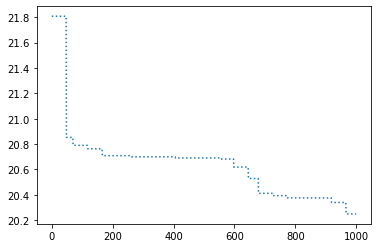

In [ ]:
plt.plot(v[:, 0], linestyle = 'dotted')
plt.show()

### Downscale value function

With code from https://stackoverflow.com/questions/14916545/numpy-rebinning-a-2d-array

In [ ]:
# bin shape
a = 50
b = 1
vAvg = v[0:1000, :].reshape([1000 // a, a, v.shape[1] // b, b]).mean(3).mean(1)

In [ ]:
vAvg.shape

(20, 210241)

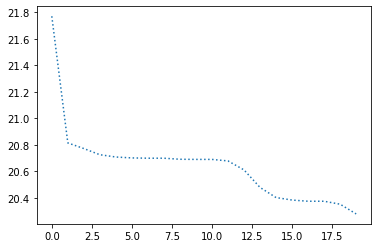

In [ ]:
plt.plot(vAvg[:, 0], linestyle = 'dotted')
plt.show()

## Process features
Here X_train is 210240*24. We use 12 RTPs and 12 DAPs.

In [ ]:
X_train = np.zeros((T, 24))

### DAP

Include 12hrs of DAP

In [ ]:
# Subsample DAP
DAP_sub = DAP[::12]

# Select dates and flatten
lambda_DA_sub = DAP_sub[:, (len(DAP_sub[0])-lastDay+start-2):(len(DAP_sub[0])-lastDay+stop+1)]
tlambda_DA_sub = lambda_DA_sub.flatten('F')

# Select previous 11 prices and current price
for t in range(T):
    X_train[t, 0:12] = tlambda_DA_sub[int(t/12)+13 : int(t/12)+25]

### RTP

Include 1hr of RTP

In [ ]:
# Select previous 11 prices and current price
for t in range(T):
    X_train[t, 12:24] = tlambda[t+277 : t+289]

## Generate y_train

In [ ]:
y_train = vAvg.T[0:T, :]

In [ ]:
y_train.shape

(210240, 20)

## Train model

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(24,)),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dense(20)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                1200      
                                                                 
 dense_1 (Dense)             (None, 20)                980       
                                                                 
Total params: 2,180
Trainable params: 2,180
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Since we are doing regression, we use mean squared error here
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError())

In [ ]:
# TODO: batched training
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
6570/6570 [==============================] - 13s 2ms/step - loss: 297.4645
Epoch 2/10
6570/6570 [==============================] - 12s 2ms/step - loss: 255.1010
Epoch 3/10
6570/6570 [==============================] - 12s 2ms/step - loss: 247.3562
Epoch 4/10
6570/6570 [==============================] - 13s 2ms/step - loss: 244.4928
Epoch 5/10
6570/6570 [==============================] - 12s 2ms/step - loss: 242.1982
Epoch 6/10
6570/6570 [==============================] - 13s 2ms/step - loss: 240.3467
Epoch 7/10
6570/6570 [==============================] - 13s 2ms/step - loss: 237.9628
Epoch 8/10
6570/6570 [==============================] - 12s 2ms/step - loss: 236.9455
Epoch 9/10
6570/6570 [==============================] - 12s 2ms/step - loss: 234.5594
Epoch 10/10
6570/6570 [==============================] - 12s 2ms/step - loss: 234.0186


## Test using using X_train

In [ ]:
prediction = model.predict( np.array([X_train[11],]))
print(prediction)

[[32.791916 32.2881   31.39452  30.018068 29.94136  30.134727 29.42462
  29.220804 28.734753 28.035486 28.085815 27.55586  27.381893 27.070223
  26.543968 26.363857 25.900015 25.318758 24.948906 24.188848]]


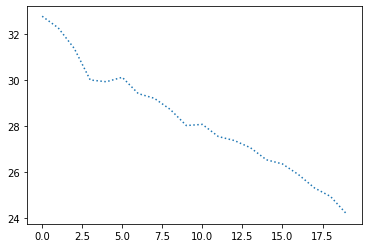

In [ ]:
plt.plot(prediction[0], linestyle = 'dotted')
plt.show()

### Predict value function

In [ ]:
v2 = model.predict(X_train)

In [ ]:
v2.shape

(210240, 20)

In [ ]:
v2 = v2.T

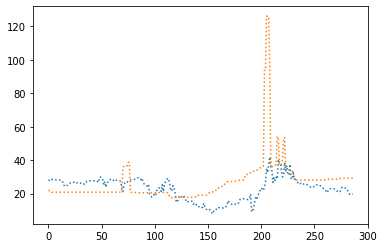

In [ ]:
plt.plot(v2[10,0:287], linestyle = 'dotted')
plt.plot(v[10,0:287], linestyle = 'dotted')
plt.show()

### Perform Arbitrage

In [ ]:
eS = np.zeros(T) # generate the SoC series
# print(eS.shape)

pS = np.zeros(T) # generate the power series
# print(eS.shape)

e = e0 # initial SoC
# print(e)


for t in range(T-1): # start from the first day and move forwards
    vv = v2[:, t+1]
    e, p = ArbValue(tlambda[288+t], vv, e, P, 1, eta, c, v2.shape[0])
    eS[t] = e # record SoC
    pS[t] = p # record Power

In [ ]:
pS.shape

(210240,)

In [ ]:
tlambda.shape

(210528,)

### Result

In [ ]:
ProfitOut = np.sum(pS * tlambda[288:]) - np.sum(c * pS[pS>0])
Revenue = np.sum(pS * tlambda[288:])
print(ProfitOut)
print(Revenue)
# 33899.55838450291
# 40372.74720029238

34180.26861754656
40412.84668772199


## Test using X_test

### Select dates

In [ ]:
from datetime import date

startTest = date.toordinal(date(2019, 1, 1)) + 366 - 1
stopTest = date.toordinal(date(2019, 12, 31)) + 366 - 1

In [ ]:
len(RTP[0])-lastDay+stop

3650

### Process Features

In [ ]:
T2 = int((stopTest-startTest+1)*24/Ts)
T2

105120

Create X_test to hold 24 features

In [ ]:
X_test = np.zeros((T2, 24))

### RTP

In [ ]:
tlambda_RTP_test = RTP[:, (len(RTP[0])-lastDay+startTest-2):(len(RTP[0])-lastDay+stop)]
print(tlambda_RTP_test.shape)
tlambda_RTP_test = tlambda_RTP_test.flatten('F')
print(tlambda_RTP_test.shape)

(288, 366)
(105408,)


In [ ]:
for t in range(T2):
    X_test[t, 12:24] = tlambda_RTP_test[t+277 : t+289]

In [ ]:
len(RTP[0])-lastDay+startTest-1

3285

In [ ]:
X_test[0]

array([30.15, 29.6 , 30.42, 37.58, 45.38, 39.  , 34.69, 29.35, 26.84,
       26.06, 25.2 , 25.57, 27.76, 26.43,  4.77,  4.77, 21.14, 28.27,
       27.58, 23.27,  4.77,  1.1 ,  3.6 ,  7.2 ])

### DAP

In [ ]:
DAP_sub = DAP[::12]

In [ ]:
# tlambda_DAP_test = DAP[:, (len(DAP[0])-lastDayTest+startTest-2):(len(DAP[0])-lastDayTest+stopTest)]
# print(tlambda_DAP_test.shape)
# tlambda_DAP_test = tlambda_DAP_test.flatten('F')
# print(tlambda_DAP_test.shape)

lambda_DA_sub = DAP_sub[:, (len(DAP_sub[0])-lastDay+startTest-2):(len(DAP_sub[0])-lastDay+stop+1)]
tlambda_DA_sub = lambda_DA_sub.flatten('F')
tlambda_DA_sub.shape

(8784,)

In [ ]:
for t in range(T2):
    X_test[t, 0:12] = tlambda_DA_sub[int(t/12)+13 : int(t/12)+25]

In [ ]:
# for t in range(T2-1):
#     X_test[t, 0:12] = tlambda_DAP_test[t+145 : t+289 : 12]

In [ ]:
X_test

array([[30.15, 29.6 , 30.42, ...,  1.1 ,  3.6 ,  7.2 ],
       [30.15, 29.6 , 30.42, ...,  3.6 ,  7.2 ,  7.13],
       [30.15, 29.6 , 30.42, ...,  7.2 ,  7.13, 50.89],
       ...,
       [20.56, 20.17, 19.74, ..., 19.83, 20.71, 20.71],
       [20.56, 20.17, 19.74, ..., 20.71, 20.71, 21.78],
       [20.56, 20.17, 19.74, ..., 20.71, 21.78, 16.58]])

### Predict

In [ ]:
v3 = model.predict(X_test)

In [ ]:
v3.shape

(105120, 20)

In [ ]:
v3 = v3.T

In [ ]:
eS_test = np.zeros(T2) # generate the SoC series
# print(eS.shape)

pS_test = np.zeros(T2) # generate the power series
# print(eS.shape)

e = e0 # initial SoC
# print(e)
 

for t in range(T2-1): # start from the first day and move forwards
    vv = v3[:, t+1]
    e, p = ArbValue(tlambda_RTP_test[288+t], vv, e, P, 1, eta, c, v3.shape[0])
    eS_test[t] = e # record SoC
    pS_test[t] = p # record Power

In [ ]:
ProfitOutTest = np.sum(pS_test * tlambda_RTP_test[288:]) - np.sum(c * pS_test[pS_test>0])
RevenueTest = np.sum(pS_test * tlambda_RTP_test[288:])
print(ProfitOutTest)
print(RevenueTest)

7885.155423632765
9916.540511352063


In [ ]:
tlambda_RTP_test[288:289]

array([7.2])

# Code Archive

In [ ]:
# # Downsize DAP to hourly prices
# DAP_sub = DAP[::12]

# print(DAP_sub.shape)

# print(DAP_sub[:, 0])

# print(DAP_sub.shape)

# # Since DAP every hour is the same, we include t-11h to t+12h.
# lambda_DAP = DAP_sub[:, (len(DAP_sub[0])-lastDay+start-2):(len(DAP_sub[0])-lastDay+stop+1)]
# print(lambda_DAP.shape)
# lambda_DAP = lambda_DAP.flatten('F')
# print(lambda_DAP.shape)


# # Downsize RTP to hourly prices
# RTP_sub = RTP[::12]

# print(RTP_sub.shape)

# print(RTP_sub[:, 0])

# lambda_RTP = RTP_sub[:, (len(RTP_sub[0])-lastDay+start-2):(len(RTP_sub[0])-lastDay+stop)]
# print(lambda_RTP.shape)
# lambda_RTP = lambda_RTP.flatten('F')
# print(lambda_RTP.shape)

# print(lambda_RTP)